<img src="logo_UTN.svg" align="right" width="150" /> 

## Teoría de Circuitos II

### Tarea Semanal 15

#### Por Matías Marfisi


# Consigna

#### Filtro pasa-bajos Bessel de 3er. orden 

![Consigna](Consigna1.png "Consigna")

## Desarrollo

Utilizo la tabla de coeficiente de polinomios de bessel. La $T(s)$ tendrá la forma $T(s)=\frac{B_n(0)}{B_n(s)}$

![1](CoeficientesBessel.png "1")

![1](Desarrollo/1.jpeg "1")

## Simulacion

In [1]:
# Módulos para Jupyter

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
#%%  Inicialización de librerías
# Setup inline graphics: Esto lo hacemos para que el tamaño de la salida, 
# sea un poco más adecuada al tamaño del documento
mpl.rcParams['figure.figsize'] = (25,15)

#%% Esto tiene que ver con cuestiones de presentación de los gráficos,
# NO ES IMPORTANTE
fig_sz_x = 14
fig_sz_y = 13
fig_dpi = 80 # dpi

#fig_font_family = 'Ubuntu'
fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})
#plt.rcParams.update({'font.family':fig_font_family})

# módulo de SciPy
from scipy import signal as sig

import sympy as sp
import splane as tc2
from schemdraw import Drawing
from schemdraw.elements import  Resistor, Capacitor, Inductor
import numpy as np
import ltspice

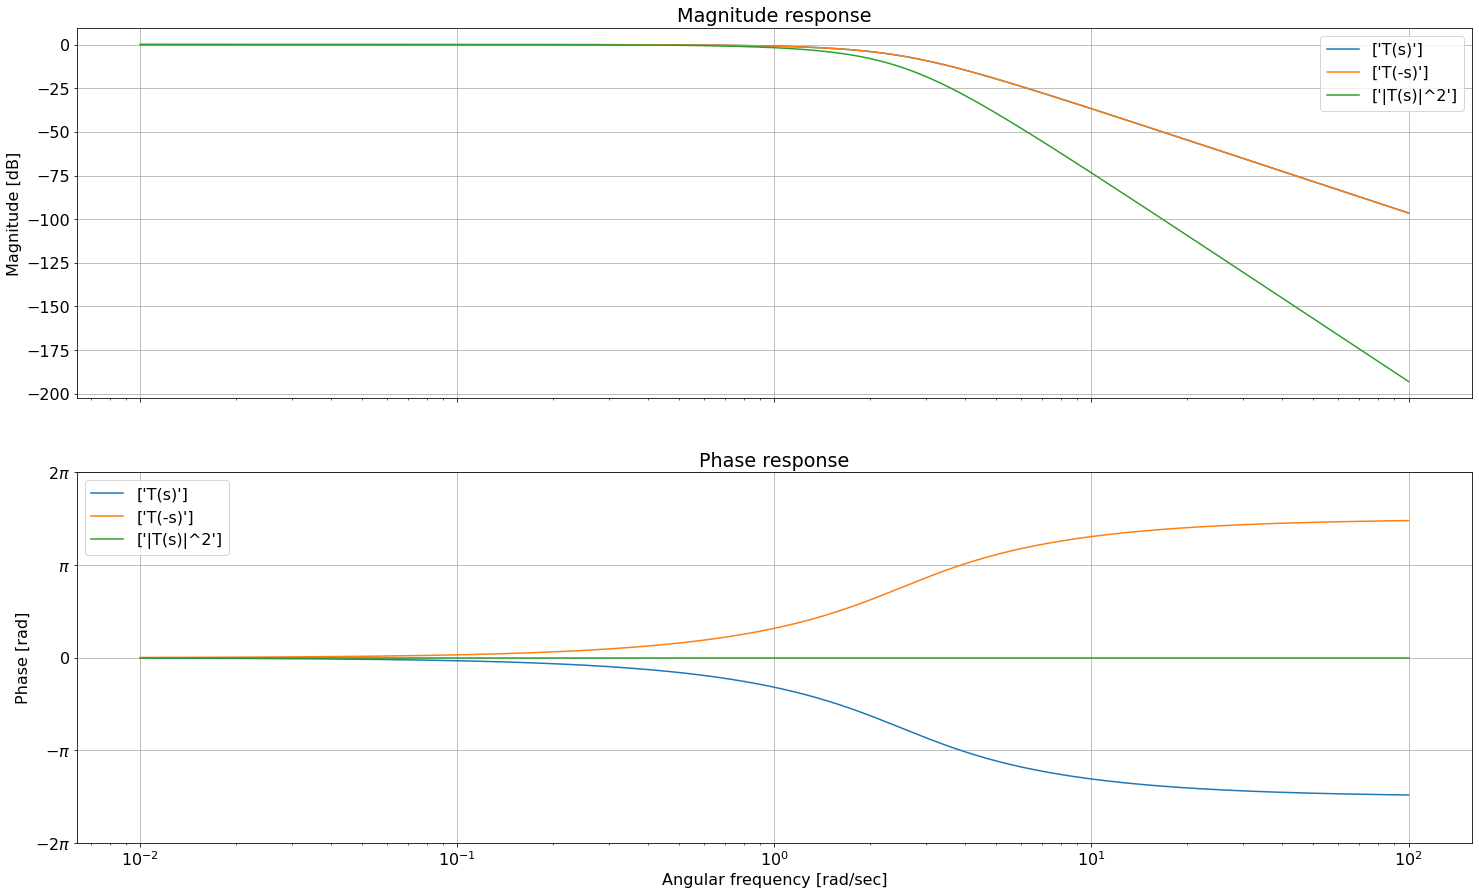

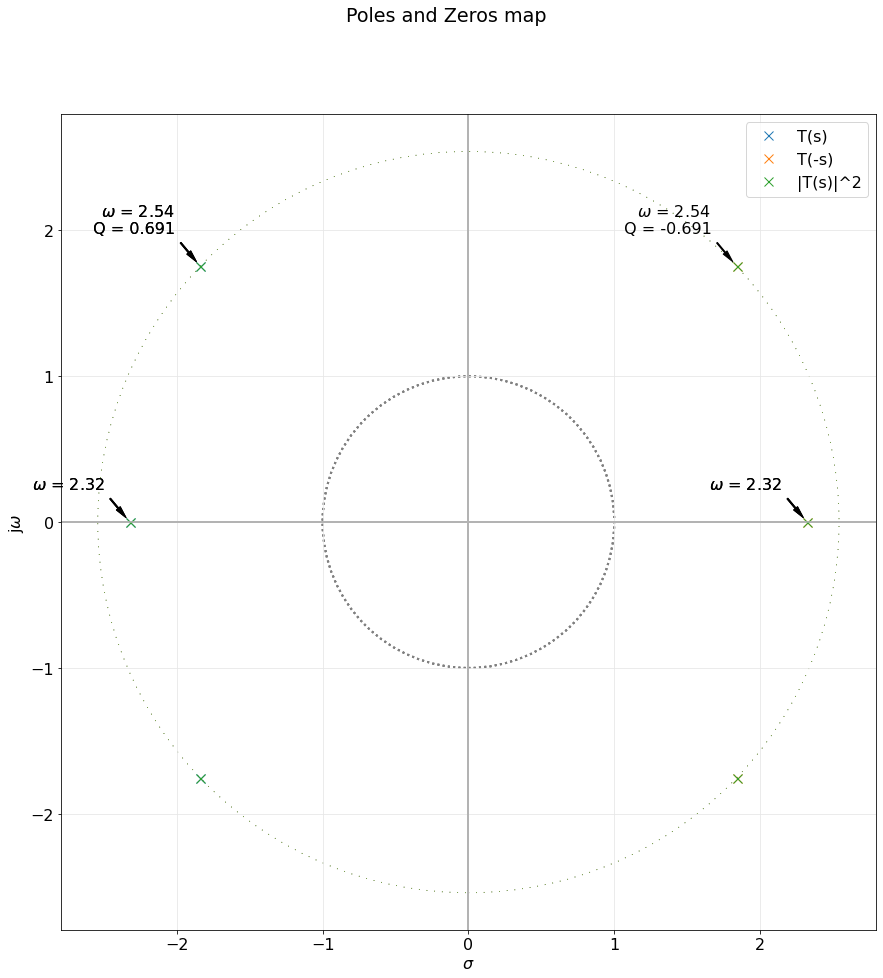

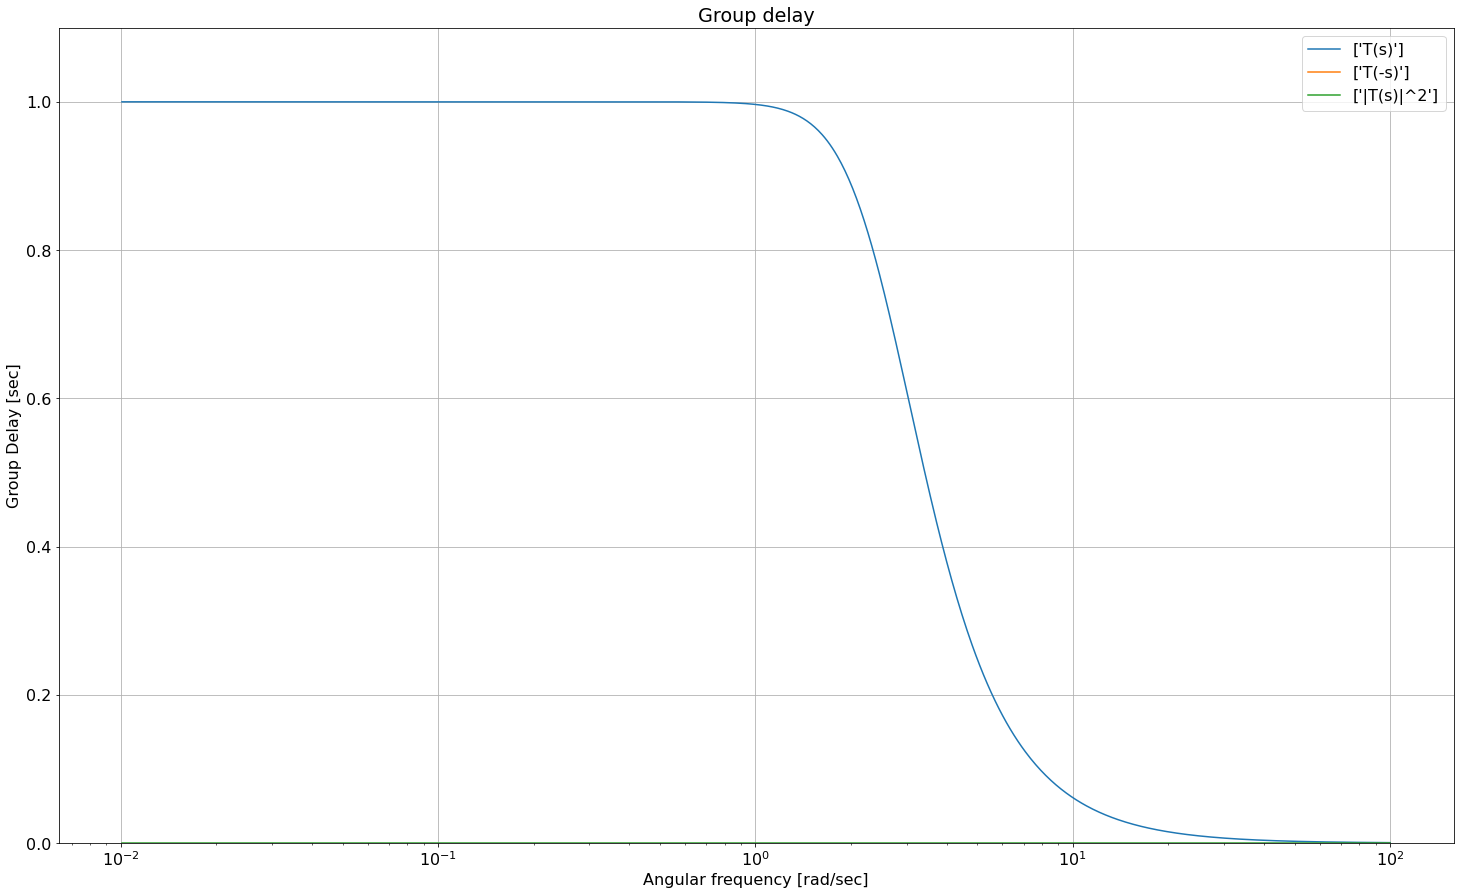

In [2]:
# Verificacion de T(s), T(-s), |T(s)|^2c

from splane import analyze_sys, pretty_print_bicuad_omegayq

K = 1
num1 = K * np.array([15])
den1 = np.array([1, 6, 15, 15])
den2 = np.array([-1, 6, -15, 15])

num_s2 = np.array([15*15])
den_s2 = np.array([-1, 0, 6, 0, -45, 0, 225])

sos_1 = sig.TransferFunction(num1,den1)
sos_2 = sig.TransferFunction(num1,den2)
sos_s2 = sig.TransferFunction(num_s2,den_s2)

all_sos = [sos_1, sos_2, sos_s2]

#pretty_print_bicuad_omegayq(num1,den1)

plt.close('all')
analyze_sys(all_sos, sys_name=['T(s)', 'T(-s)', '|T(s)|^2'])

In [3]:
# Obtencion de S11 con |S21|^2
s = sp.symbols('s ', complex=True)

s11sq = (-s**6 + 6*s**4- 45*s**2)/(-s**6 + 6*s**4 - 45*s**2 + 225)

s11 = tc2.modsq2mod_s(s11sq).evalf(4)

print(s11)

z1 = sp.simplify(sp.expand(sp.simplify(sp.expand(1+s11))/sp.simplify(sp.expand((1-s11)))))

print(z1)

s*(s**2 + 4.406*s + 6.708)/(s**3 + 6.0*s**2 + 15.0*s + 15.0)
(2*s**3 + 10.41*s**2 + 21.71*s + 15.0)/(1.594*s**2 + 8.292*s + 15.0)


### Síntesis normalizada

(2*s**3 + 10.41*s**2 + 21.71*s + 15.0)/(1.594*s**2 + 8.292*s + 15.0)


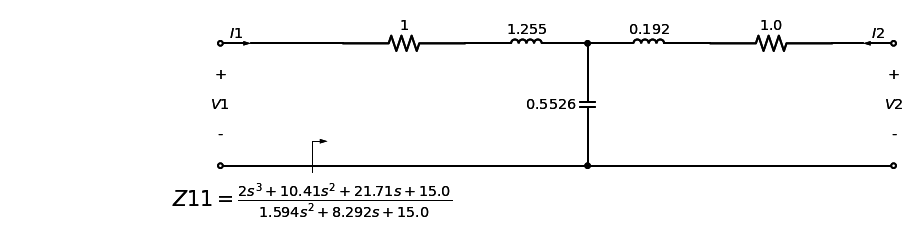

In [4]:
# Cauer en infinito para obtener red
s = sp.symbols('s', complex=True)

norma_Z = 50
norma_frec = 10e6#2*np.pi

Z11 = z1 # De celda anterior

print(Z11)
Z2, ZL1 = tc2.remover_polo_infinito(Z11)
L1 = (ZL1/s).round(4)
L1_V = (L1*norma_Z/norma_frec).round(12) 
Y2 = 1/Z2

for a in sp.preorder_traversal(Y2):
    if isinstance(a, sp.Float):
        Y2 = Y2.subs(a, round(a, 4))   

Y3, YC2 = tc2.remover_polo_infinito(Y2)
C2 = (YC2/s).round(4)
C2_V = (C2/(norma_Z*norma_frec)).round(12) 
Z3 = 1/Y3

for a in sp.preorder_traversal(Z3):
    if isinstance(a, sp.Float):
        Z3 = Z3.subs(a, round(a, 3))
        
Z4, ZL3 = tc2.remover_polo_infinito(Z3)
L3 = (ZL3/s).round(4)
L3_V = (L3*norma_Z/norma_frec).round(12) 
Y4 = 1/Z4

for a in sp.preorder_traversal(Y4):
    if isinstance(a, sp.Float):
        Y4 = Y4.subs(a, round(a, 5))
        
RL = 1/Y4       
RL_V = RL * norma_Z

RG = '1'
RG_V = '50'

# Dibujamos la red resultante:
    
d = Drawing(unit=4)  # unit=2 makes elements have shorter than normal leads

d = tc2.dibujar_puerto_entrada(d,
                        voltage_lbl = ('+', '$V1$', '-'), 
                        current_lbl = '$I1$')

d, zz_lbl = tc2.dibujar_funcion_exc_abajo(d, 
                                          'Z11',  
                                          Z11, 
                                          hacia_salida = True,
                                          k_gap_width = 0.5)

d = tc2.dibujar_elemento_serie(d, Resistor, RG)
d = tc2.dibujar_elemento_serie(d, Inductor, L1)
d = tc2.dibujar_elemento_derivacion(d, Capacitor, C2)
d = tc2.dibujar_elemento_serie(d, Inductor, L3)
d = tc2.dibujar_elemento_serie(d, Resistor, RL)
#d = tc2.dibujar_espacio_derivacion(d)
#d = tc2.dibujar_elemento_derivacion(d, Capacitor, C1)

d = tc2.dibujar_puerto_salida(d,
                        voltage_lbl = ('+', '$V2$', '-'), 
                        current_lbl = '$I2$')


display(d)


### LTSpice normalizado

![Red](Desarrollo/RedFinal.png "Red")

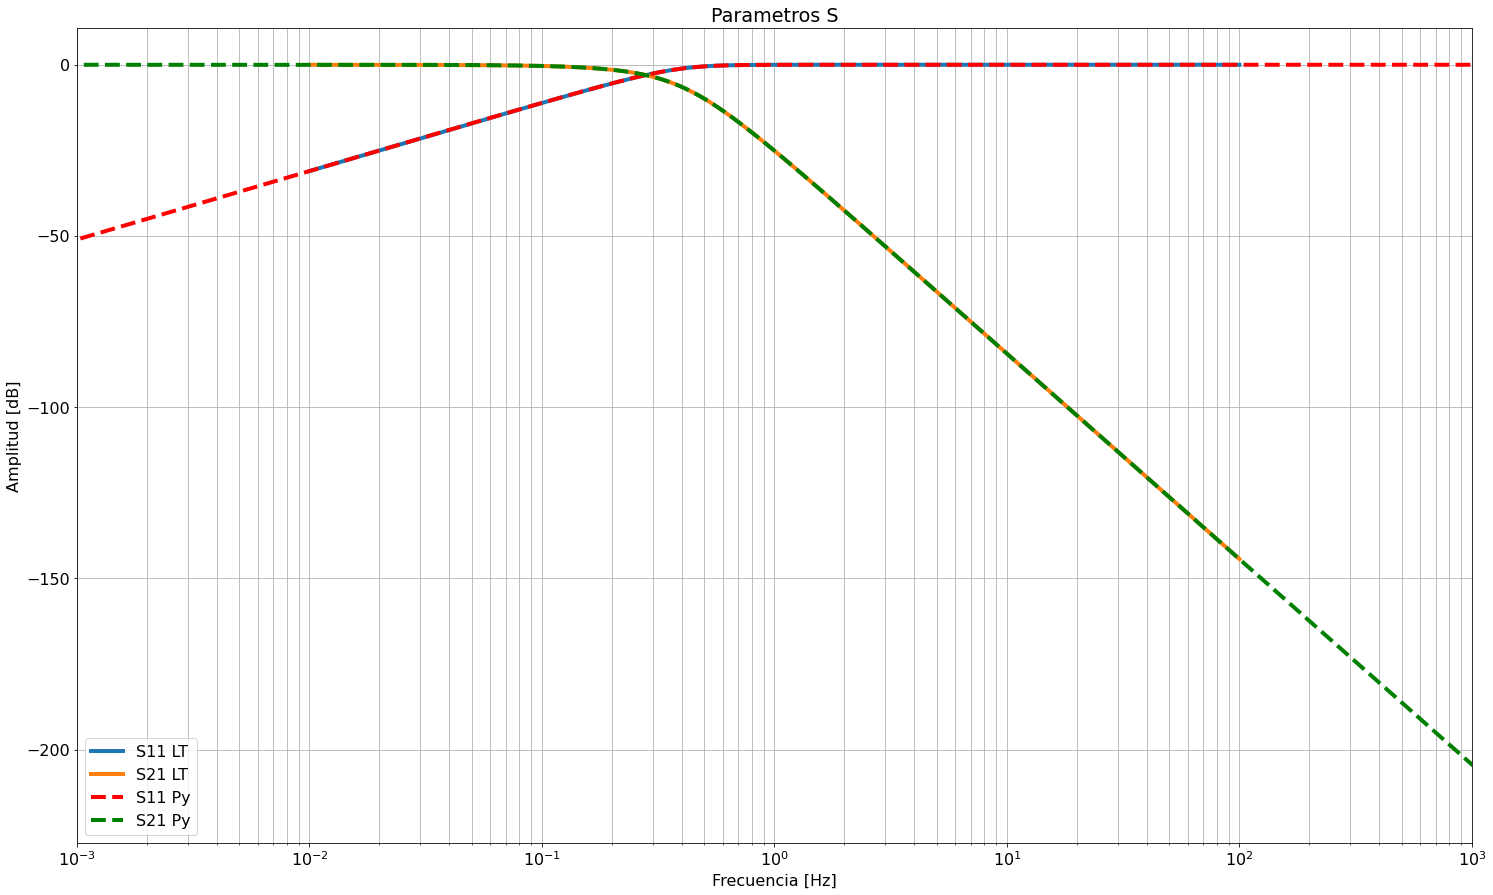

In [5]:
# Importo simulaciones de LTSpice, S11 S21 analitico vs simulacion
l = ltspice.Ltspice('Simulacion/EJ1.raw')
l.parse()

freq = l.get_frequency()
S11_LT = l.get_data('S11(v1)')
S21_LT = l.get_data('S21(v1)')

fig, ax = plt.subplots(1,1)

ax.grid(visible='true', which='both', axis='both') 
ax.legend(['LTSpice']) 
ax.set_ylabel('Amplitud [dB]') 
ax.set_xlabel('Frecuencia [Hz]') 
ax.set_xlim([0.001, 1000]) 
    
ax.set_title('Parametros S') 
ax.semilogx(freq, 20 * np.log10(abs(S11_LT)), linewidth=4, label='LTSpice') 
ax.semilogx(freq, 20 * np.log10(abs(S21_LT)), linewidth=4, label='LTSpice') 


# Obtengo respuesta con freqs
num_s11 = np.array([1, 4.406, 6.708, 0])
den_s11 = np.array([1, 6, 15, 15])

num_s21 = np.array([15])
den_s21 = np.array([1, 6, 15, 15])

w = np.logspace(-4, 4, 1000)

_, S11_A = sig.freqs(num_s11, den_s11, w)
_, S21_A = sig.freqs(num_s21, den_s21, w)

ax.semilogx(w / (2*np.pi), 20 * np.log10(abs(S11_A)), 'r--', linewidth=4, label='Freqs') 
ax.semilogx(w / (2*np.pi), 20 * np.log10(abs(S21_A)), 'g--', linewidth=4, label='Freqs') 

ax.legend(['S11 LT', 'S21 LT', 'S11 Py', 'S21 Py']) 

![Sims](Desarrollo/S11_S21_LT.png "Sims")

Se observa el retardo constante en la banda de paso para S11 y S21. S11 tiene un comportamiento pasa-altos, y por lo tanto al ser el coeficiente de reflexión del puerto de entrada, simboliza reflexión nula en baja frecuencia y total reflexión en alta frecuencia. S21 representa la transferencia de potencia, siendo máxima en baja frecuencia, y mínima en alta frecuencia.

### RG = 50$\Omega$ y $\omega_c=2.\pi.10^{6} \frac{rad}{s}$

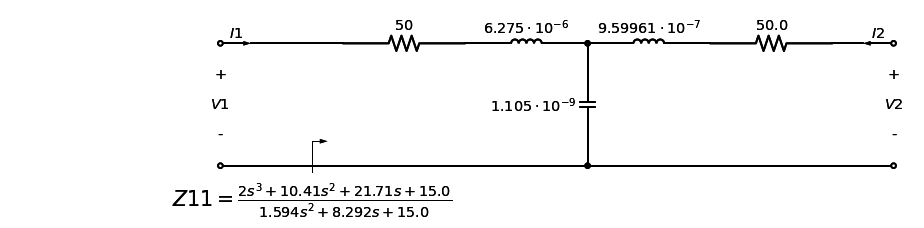

In [6]:
# Dibujamos la red resultante:
    
d = Drawing(unit=4)  # unit=2 makes elements have shorter than normal leads

d = tc2.dibujar_puerto_entrada(d,
                        voltage_lbl = ('+', '$V1$', '-'), 
                        current_lbl = '$I1$')

d, zz_lbl = tc2.dibujar_funcion_exc_abajo(d, 
                                          'Z11',  
                                          Z11, 
                                          hacia_salida = True,
                                          k_gap_width = 0.5)

d = tc2.dibujar_elemento_serie(d, Resistor, RG_V)
d = tc2.dibujar_elemento_serie(d, Inductor, L1_V)
d = tc2.dibujar_elemento_derivacion(d, Capacitor, C2_V)
d = tc2.dibujar_elemento_serie(d, Inductor, L3_V)
d = tc2.dibujar_elemento_serie(d, Resistor, RL_V)
#d = tc2.dibujar_espacio_derivacion(d)
#d = tc2.dibujar_elemento_derivacion(d, Capacitor, C1)

d = tc2.dibujar_puerto_salida(d,
                        voltage_lbl = ('+', '$V2$', '-'), 
                        current_lbl = '$I2$')


display(d)

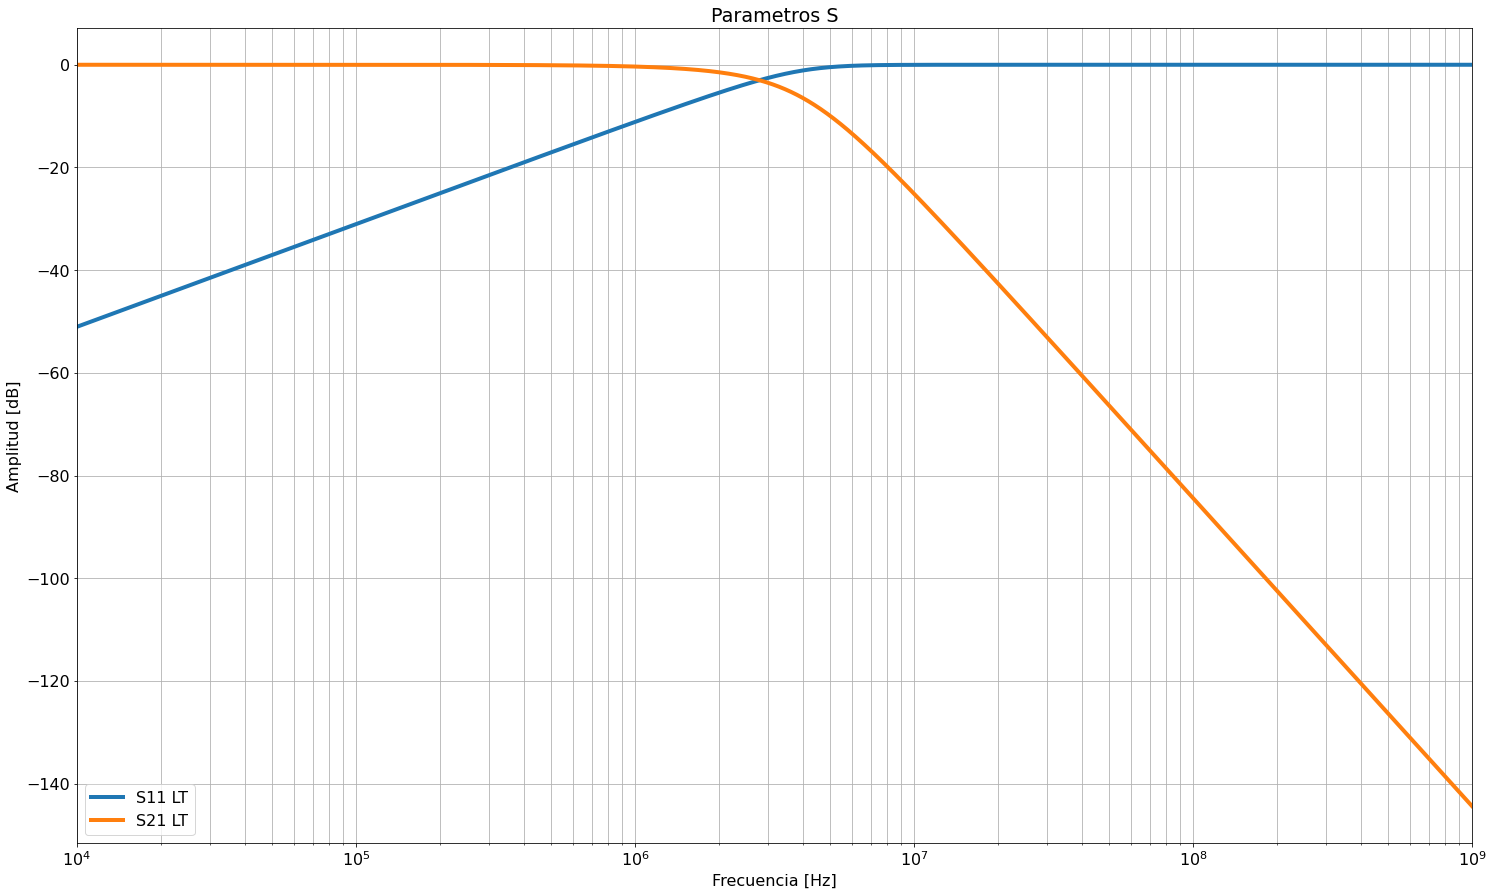

In [7]:
# Importo simulaciones de LTSpice, S11 S21 simulacion
l = ltspice.Ltspice('Simulacion/EJ1_Valores.raw')
l.parse()

freq = l.get_frequency()
S11_LT = l.get_data('S11(v1)')
S21_LT = l.get_data('S21(v1)')

fig, ax = plt.subplots(1,1)

ax.grid(visible='true', which='both', axis='both') 
ax.legend(['LTSpice']) 
ax.set_ylabel('Amplitud [dB]') 
ax.set_xlabel('Frecuencia [Hz]') 
ax.set_xlim([1e4, 1e9]) 
    
ax.set_title('Parametros S') 
ax.semilogx(freq, 20 * np.log10(abs(S11_LT)), linewidth=4, label='LTSpice') 
ax.semilogx(freq, 20 * np.log10(abs(S21_LT)), linewidth=4, label='LTSpice') 

ax.legend(['S11 LT', 'S21 LT']) 